In [4]:
DATA_PATH = 'C:/Gel_Sheet_Data/'
MOVIE_PATH = DATA_PATH +'movie60/'
GRAPH_PATH = 'C:/Gel_Sheet_Graph/'
import numpy as np
import matplotlib.pyplot as plt
from  skimage.filters import gaussian
from tqdm.notebook import trange, tqdm
import movie_structure


In [2]:
gel = np.load(MOVIE_PATH +'np/gel.npy', mmap_mode='r')


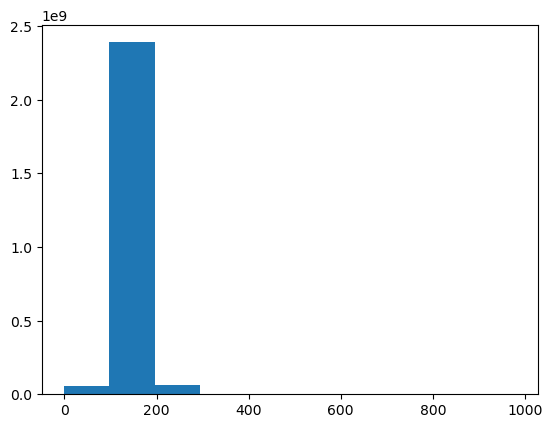

In [2]:
flat = gel.reshape(-1)
plt.hist(flat)
plt.show()

In [3]:
np.min(gel)
np.max(gel)

979.0

In [ ]:
flat = np.array(flat)
flat = np.array([flat[flat<300]])
flat = np.array([flat[flat>100]])
plt.hist(flat)
plt.show()

In [ ]:
flat = gel.reshape(-1).copy()
flat[flat>140] = np.nan
flat[flat<00] = np.nan

plt.figure()
plt.hist(flat[~np.isnan(flat)], bins = 100)
plt.show()

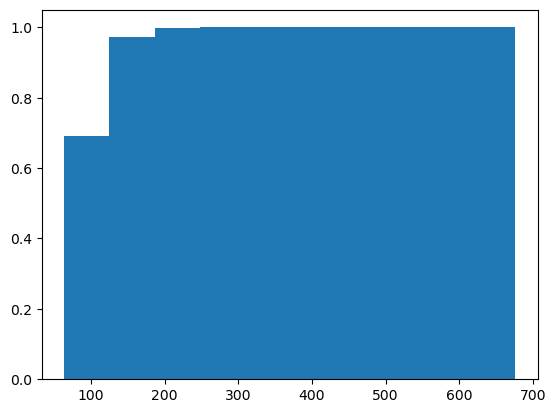

In [3]:
flat = gel[17].reshape(-1)[1:-1:10]
n, bins, patches = plt.hist(flat,cumulative=True, density=True)
plt.show()

In [4]:
min_intensity = bins[1]
max_intensity = 10000

threshold_gel = gaussian(gel[17],3)
threshold_gel[threshold_gel<min_intensity] =0
threshold_gel[threshold_gel>max_intensity] = 0
threshold_gel[np.bitwise_and(threshold_gel>= min_intensity , threshold_gel<= max_intensity)] =1

# np.save(DATA_PATH + 'tmp/t_gel.npy', threshold_gel)



In [11]:
import napari
viewer = napari.Viewer()
image = threshold_gel
viewer.add_image(image)
napari.utils.nbscreenshot(viewer)

KeyboardInterrupt: 

In [36]:
viewer.add_image(threshold_gel)


<Image layer 'threshold_gel' at 0x1b58ad47610>

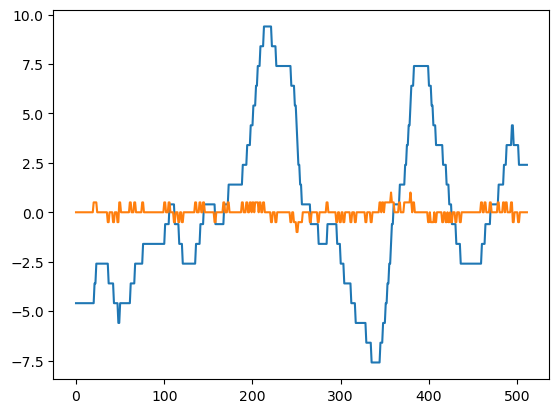

In [6]:
import movie_structure
plane = movie_structure.Vplane(threshold_gel[:,:,256], threshold_gel[:,:,256])
height = plane.set_height()
mean = np.mean(height)
height_difference = height - mean
plt.plot (height_difference)
plt.plot(np.gradient(height))
plt.show()
print()

  0%|          | 0/60 [00:00<?, ?it/s]

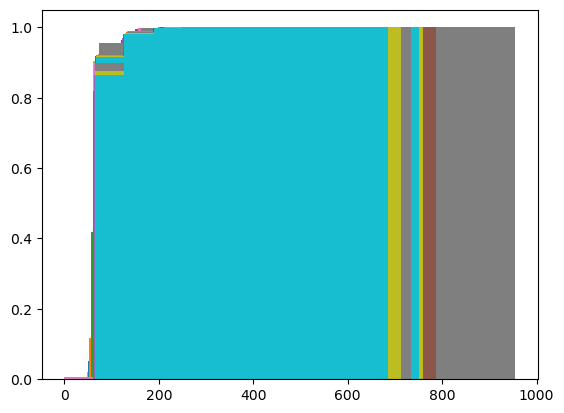

In [31]:
gradient_table = np.zeros((len(gel), gel.shape[2]))
height_table = np.zeros((len(gel), gel.shape[2]))

for t in trange(len(gel)):
    flat = gel[t].reshape(-1)[1:-1:10]
    n, bins, patches = plt.hist(flat,cumulative=True, density=True)
    min_intensity = bins[1]
    max_intensity = 10000

    gel_time_point = gaussian(gel[t],3)
    gel_time_point[gel_time_point < min_intensity] =0
    gel_time_point[gel_time_point>max_intensity] = 0
    gel_time_point[np.bitwise_and(gel_time_point>= min_intensity , gel_time_point<= max_intensity)] =1
    plane = movie_structure.Vplane(gel_time_point[:,:,256], gel_time_point[:,:,256])
    height = plane.set_height()

    height_table[t] = height - np.mean(height)
    gradient_table[t] = np.gradient(height)


In [6]:
np.nonzero(gradient_table>20)

(array([19, 19, 19, 19, 19, 19], dtype=int64),
 array([172, 173, 217, 218, 233, 234], dtype=int64))

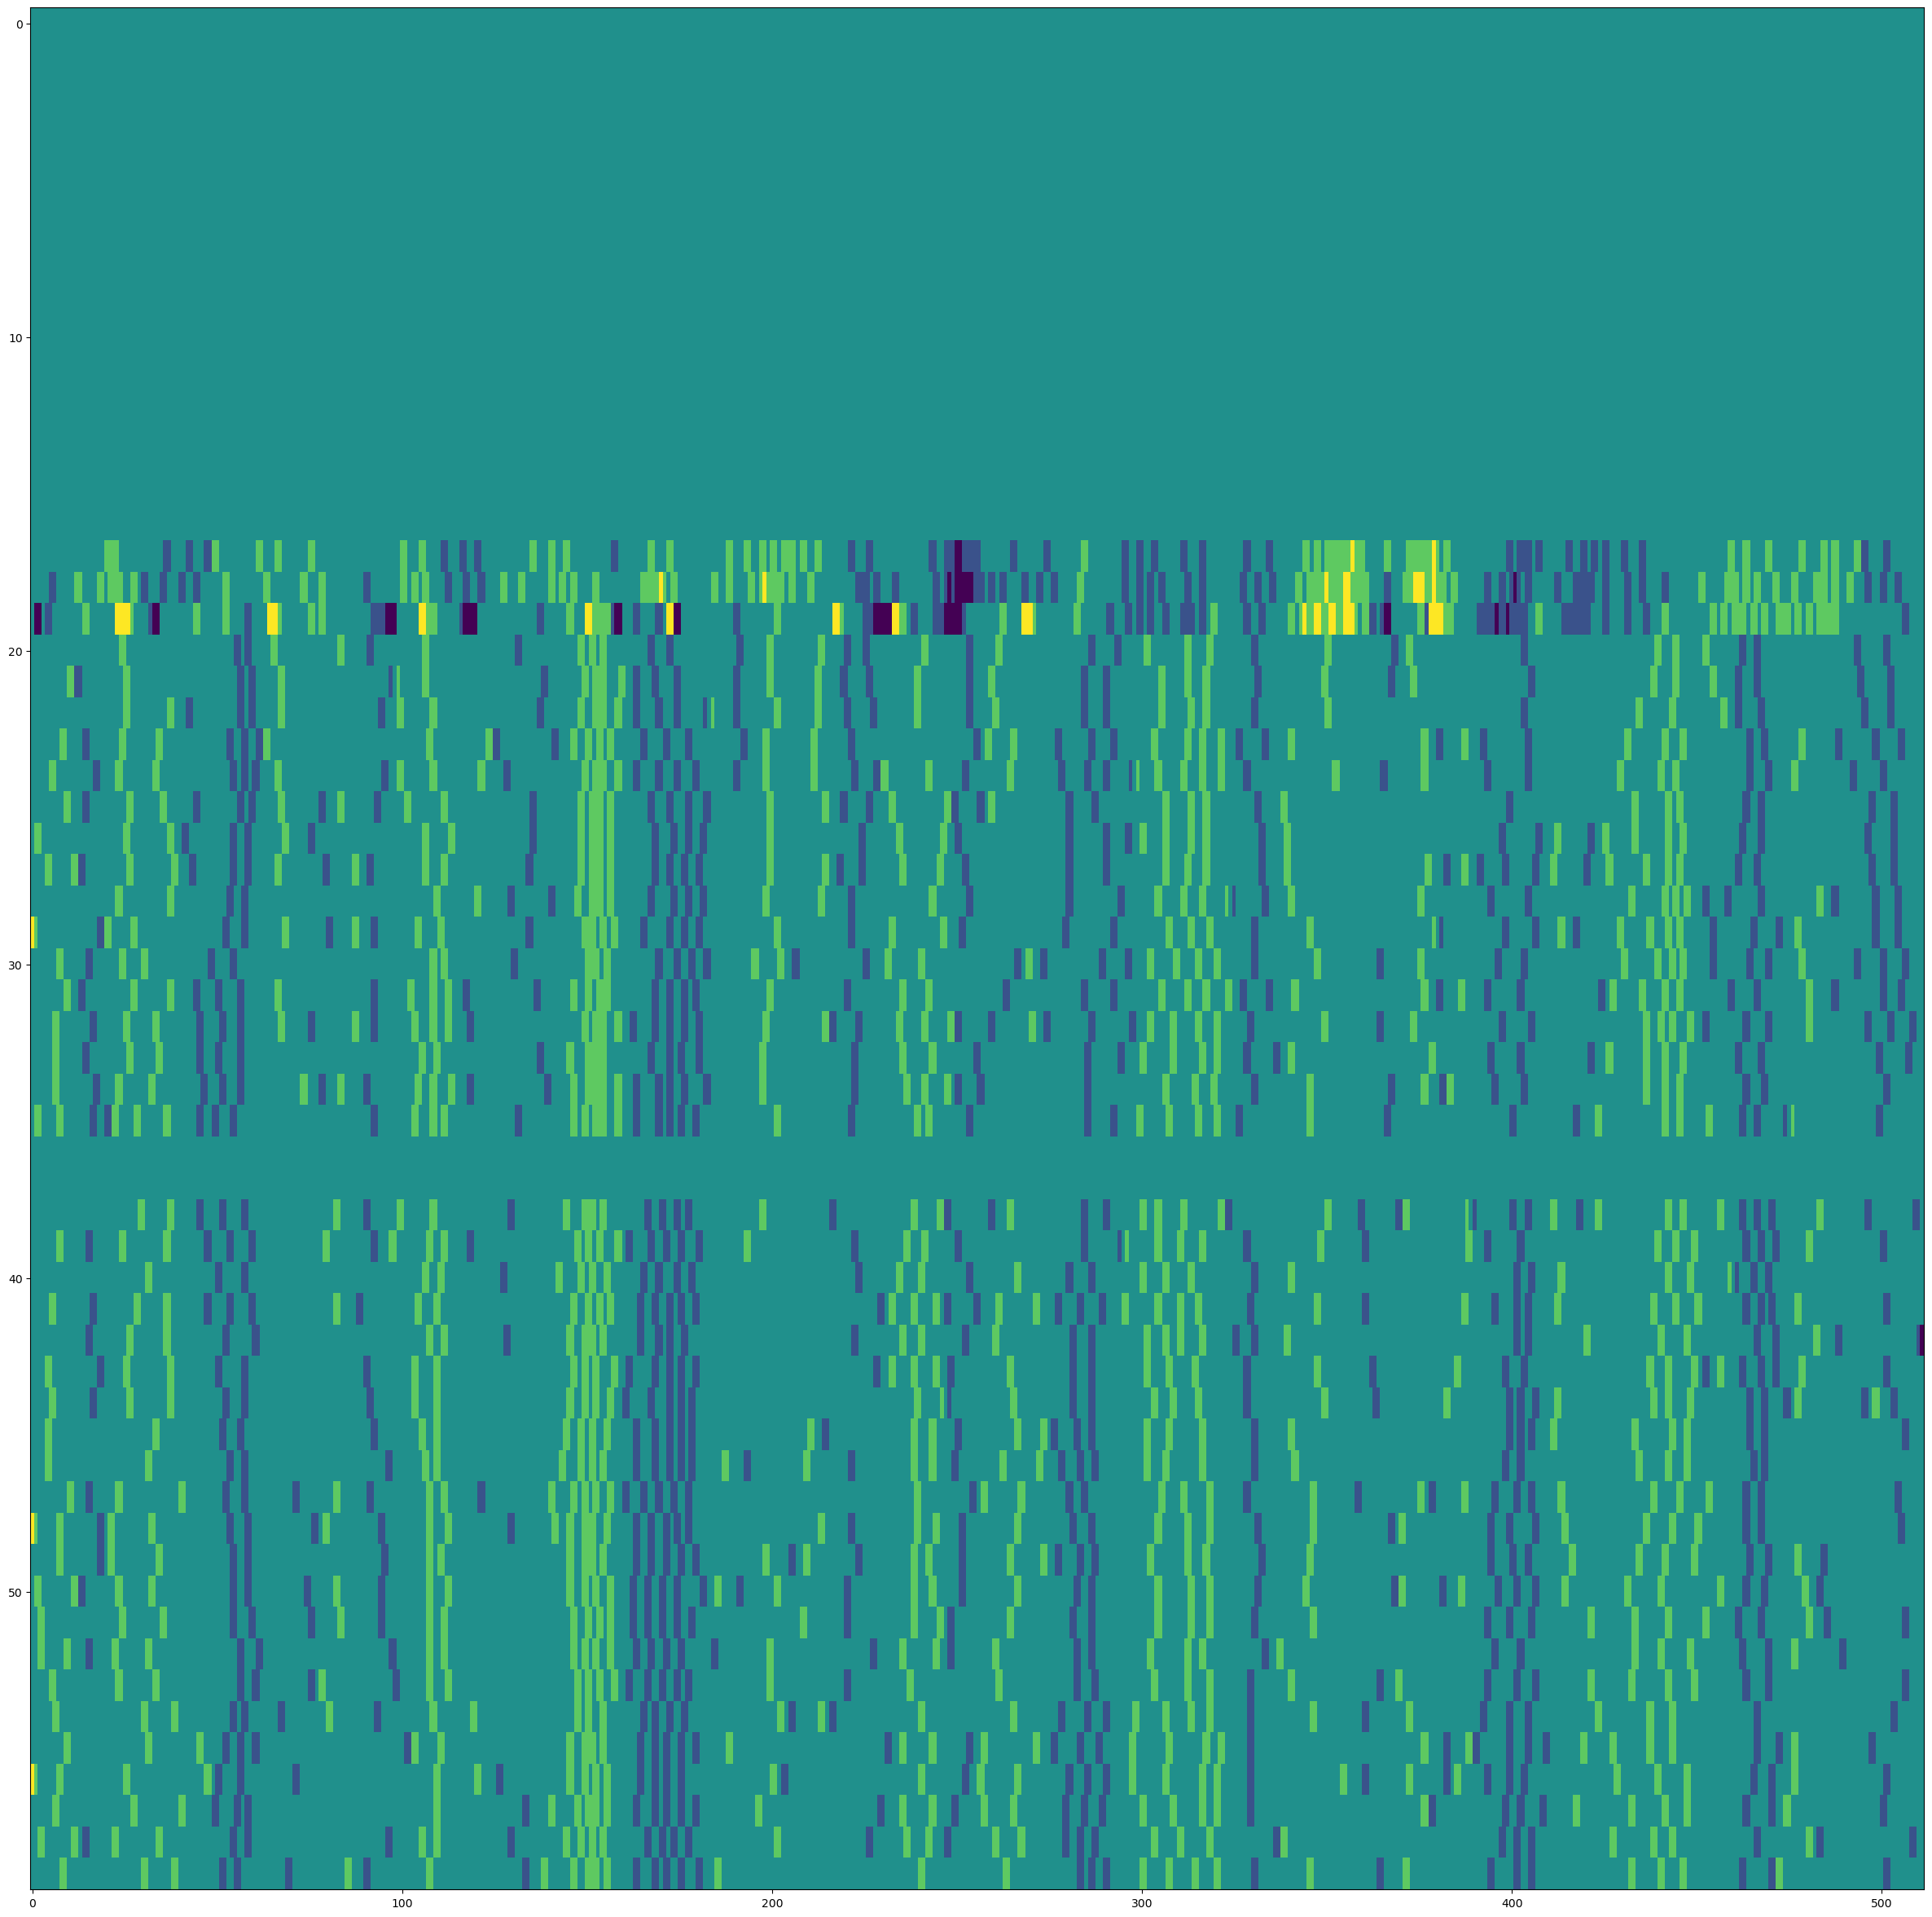

In [33]:
#gradient_table = gradient_table[range(len(gradient_table)-1,0,-1)]
plt.figure(figsize=(30,30))
plt.imshow(gradient_table, vmin= -1, vmax =1, aspect = 'auto')

plt.show()

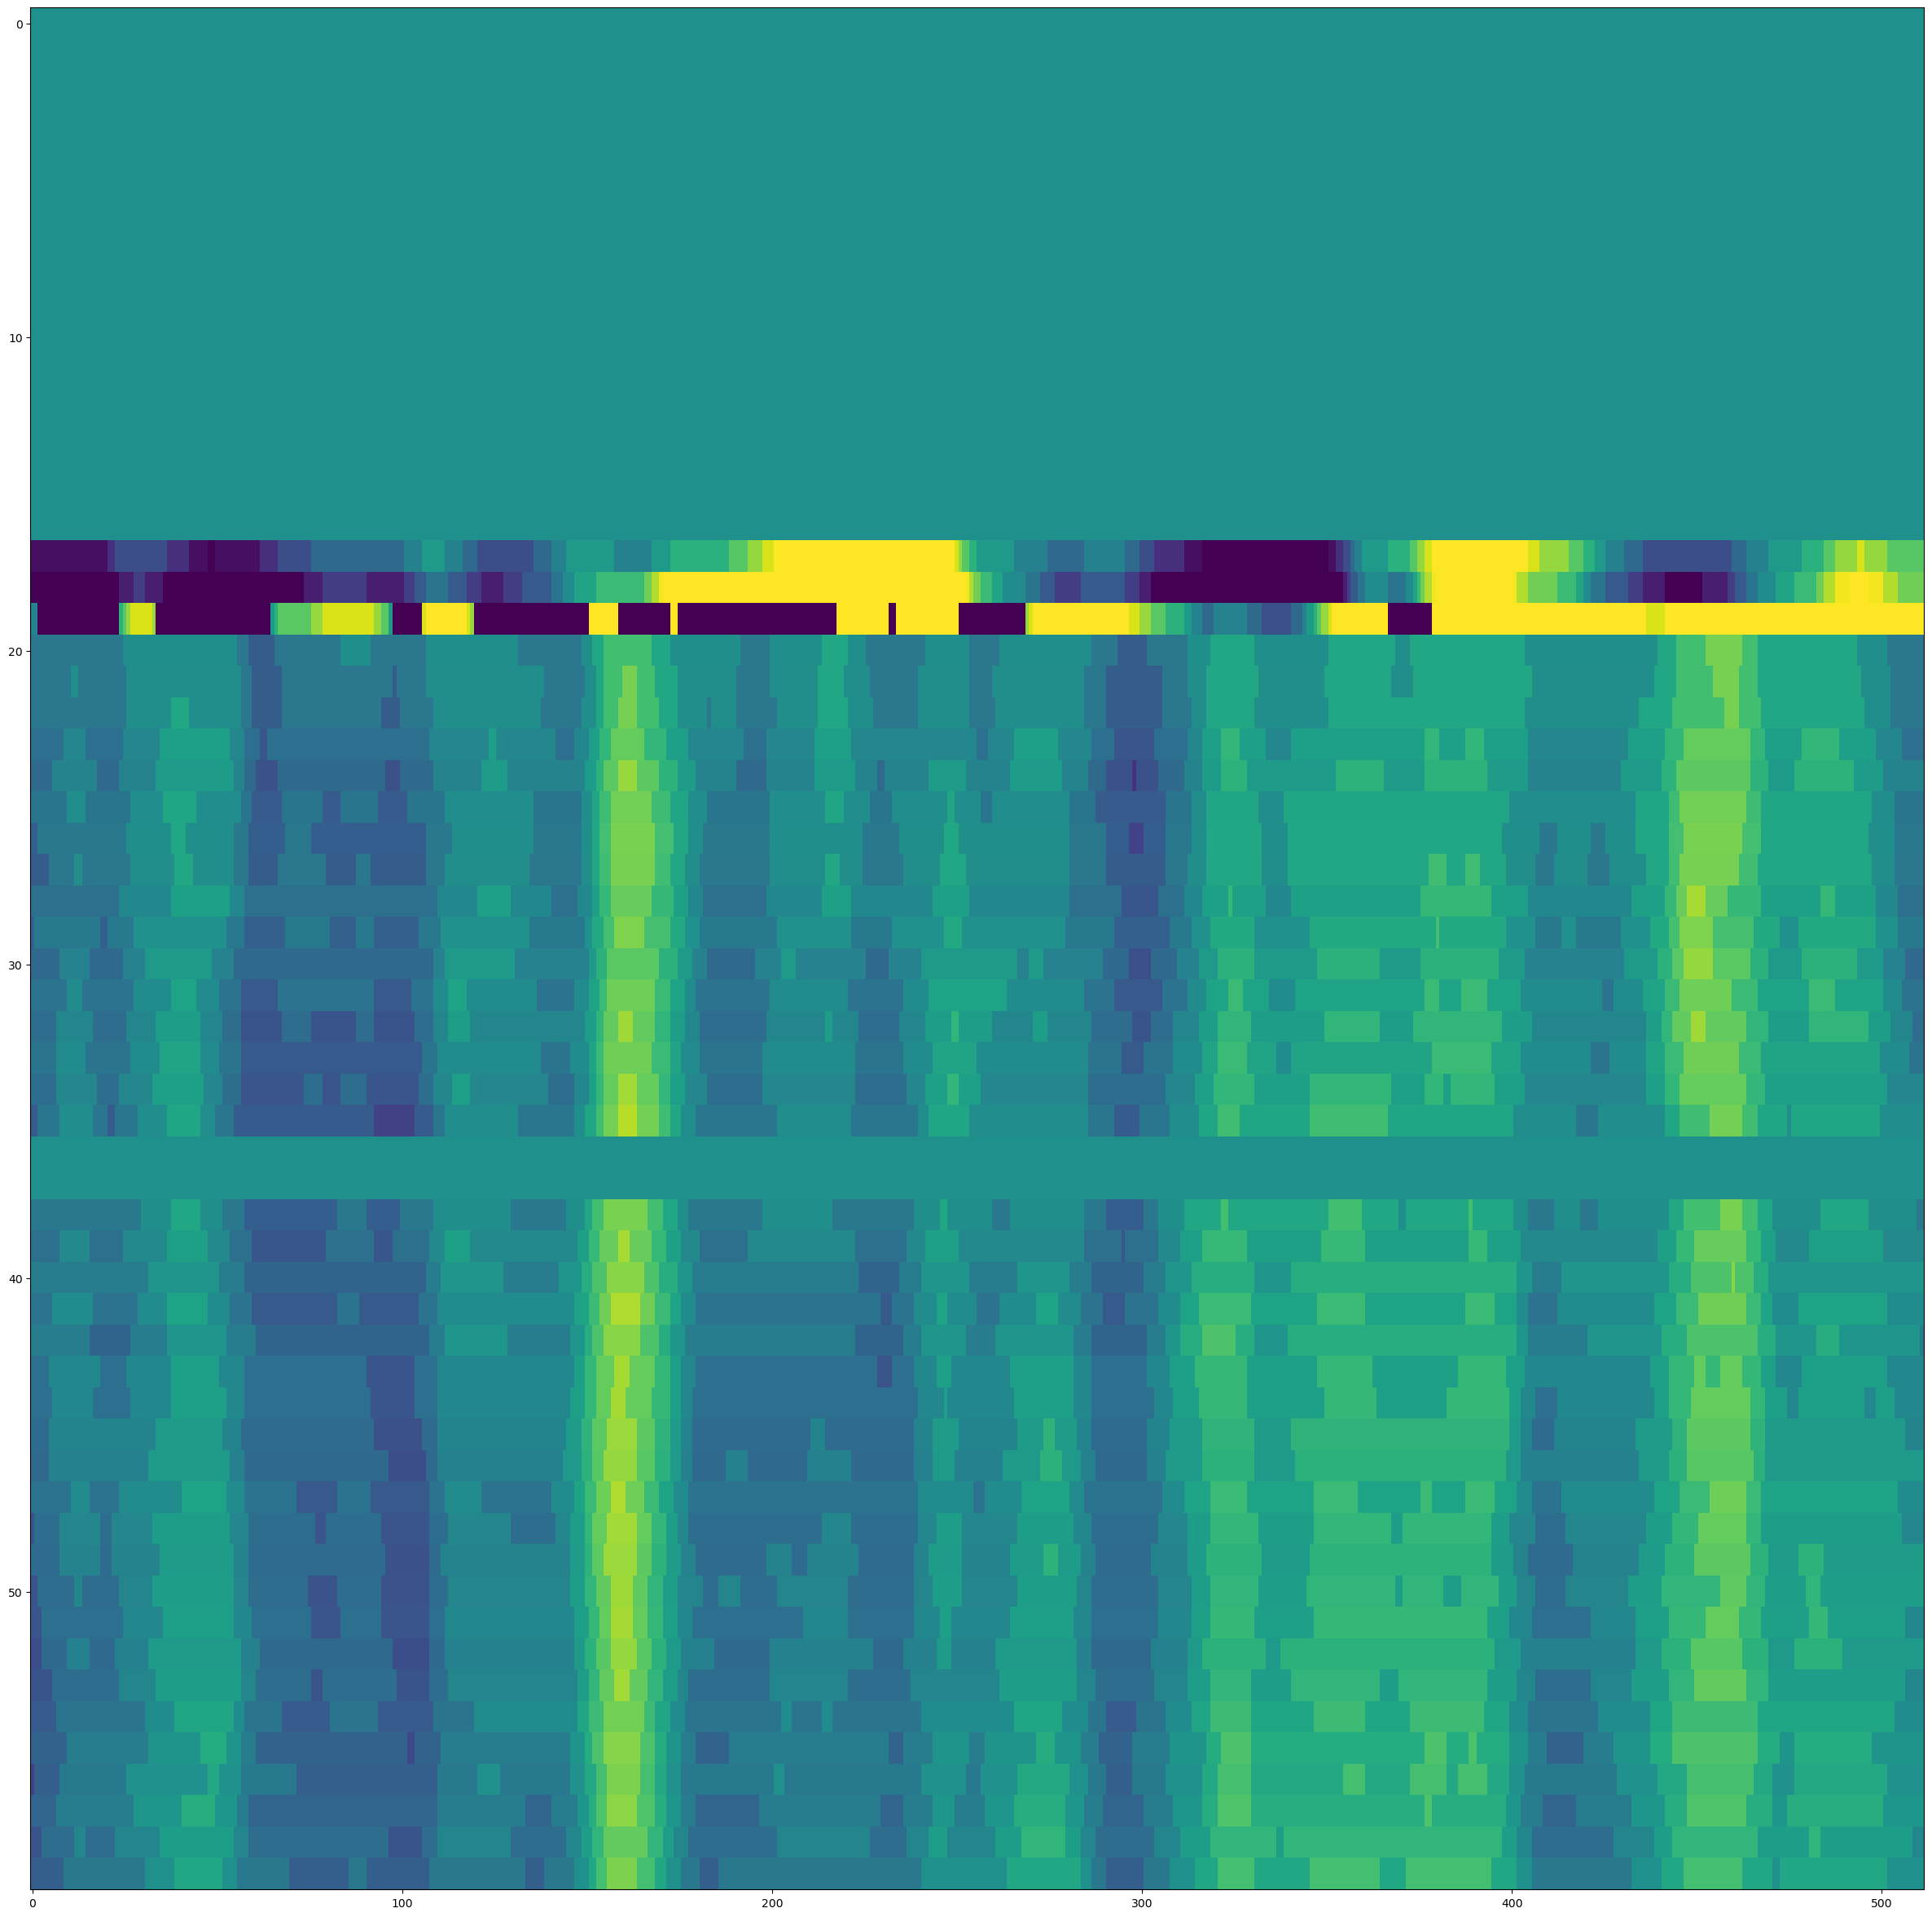

In [32]:
plt.figure(figsize=(30,30))
plt.imshow(height_table, vmin = -5, vmax =5 ,aspect = 'auto')

plt.show()